In [1]:
import numpy as np
import matplotlib.pyplot as plt
from grid import create_grid
from planning import a_star, heuristic
from planning import prune_path, smooth_path
from planning import breadth_first_search

np.set_printoptions(precision=2)

In [2]:
# read data
elev_map = np.load('./data/elev_map0.npy')
dynamic_pc = np.load('./data/dynamic_pc0.npy')
robot_pose = np.load('./data/robot_pose0.npy')
# elev_map = dynamic_pc

X = elev_map[:,0]
Y = elev_map[:,1]
Z = elev_map[:,2]; dZ = Z - robot_pose[2]
rgb = elev_map[:,3]

print('Robot pose:', robot_pose)
# print('Z_min:', np.min(Z), 'Z_max:', np.max(Z))

Robot pose: [9.46 4.04 0.11]


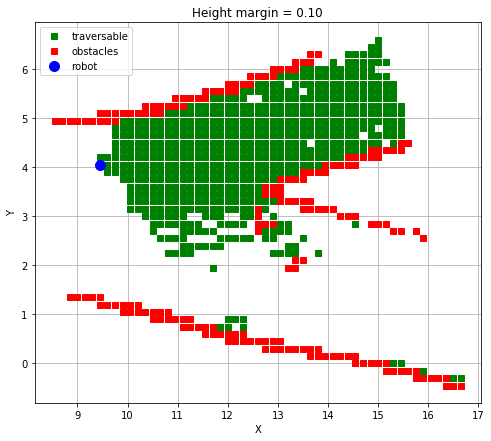

In [3]:
# local elevation map params
map_res = 0.15
margin = 0.1
unexplored_value = 0.05
safety_distance = 2*map_res
# APF params
max_apf_iters = 300
influence_r = 0.2
repulsive_coef = 100
attractive_coef = 1./50

plt.figure(figsize=(int(np.max(X)-np.min(X)), int(np.max(Y)-np.min(Y))))
plt.plot(X[dZ<=margin], Y[dZ<=margin], 's', color='green', label='traversable')
plt.plot(X[dZ>margin], Y[dZ>margin], 's', color='red', label='obstacles')
plt.plot(robot_pose[0], robot_pose[1], 'ro', color='b', markersize=10, label='robot')

plt.title('Height margin = %.2f'%margin)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid()

### Create occupancy grid

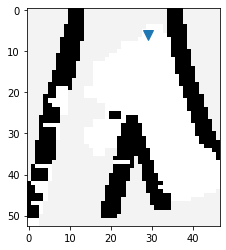

In [4]:
# minimum and maximum east coordinates
x_min = np.min(elev_map[:, 0])
x_max = np.max(elev_map[:, 0])
# minimum and maximum north coordinates
y_min = np.min(elev_map[:, 1])
y_max = np.max(elev_map[:, 1])

grid, elev_grid = create_grid(elev_map, robot_pose[2], map_res, margin, safety_distance, unexplored_value)
robot_grid_pose = (robot_pose - [x_min, y_min, 0]) // map_res

plt.imshow(1-grid, cmap='gray')
plt.plot(robot_grid_pose[1], robot_grid_pose[0], 'v', markersize=10);

### A* planning on a grid

APF: found a path.


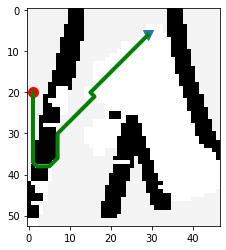

In [5]:
start_grid = (int(robot_grid_pose[0]), int(robot_grid_pose[1]))
# choose random goal location
while True:
    i,j = np.random.randint(0, grid.shape[0]), np.random.randint(0, grid.shape[1])
    if grid[i,j] != 1:
        goal_grid = (i,j)
        break

path_grid, cost = a_star(grid, heuristic, start_grid, goal_grid)

pp = np.array(path_grid)
plt.imshow(1-grid, cmap='gray')
plt.plot(start_grid[1], start_grid[0], 'v', markersize=10)
plt.plot(goal_grid[1], goal_grid[0], 'ro', markersize=10)
if len(path_grid)>0: plt.plot(pp[:, 1], pp[:, 0], 'g', linewidth=4)

### Transform path to map coordinates

In [6]:
path = [(np.array(point)*map_res+[x_min, y_min]).tolist()+[elev_grid[point]] for point in path_grid]
path = np.array(path)

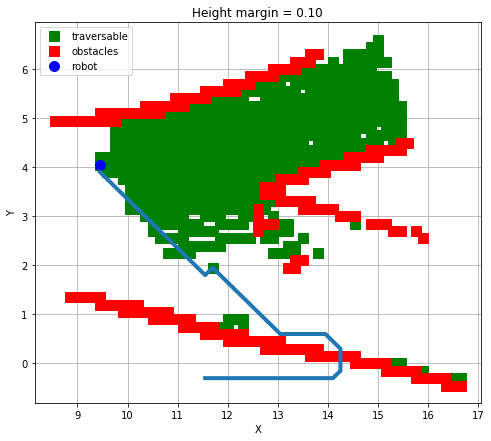

In [7]:
plt.figure(figsize=(int(np.max(X)-np.min(X)), int(np.max(Y)-np.min(Y))))
plt.plot(X[dZ<=margin], Y[dZ<=margin], 's', color='green', label='traversable', markersize=10)
plt.plot(X[dZ>margin], Y[dZ>margin], 's', color='red', label='obstacles', markersize=10)
plt.plot(robot_pose[0], robot_pose[1], 'ro', color='b', markersize=10, label='robot')
if len(path)>0: plt.plot(path[:,0], path[:,1], linewidth=4)

plt.title('Height margin = %.2f'%margin)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid()

### Path prunning and smoothing

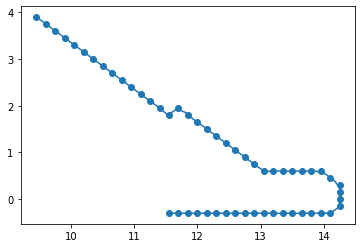

In [8]:
if len(path)>0: path_smoothed = smooth_path(path, vis=True)

### Put it all together

In [9]:
import time
tic = time.time()
grid, elev_grid = create_grid(elev_map, robot_pose[2], map_res, margin, safety_distance, unexplored_value)

# define start on a grid
robot_grid_pose = (robot_pose - [np.min(elev_map[:, 0]), np.min(elev_map[:, 1]), 0]) // map_res
start_grid = (int(robot_grid_pose[0]), int(robot_grid_pose[1]))
# choose random goal location
while True:
    i,j = np.random.randint(0, grid.shape[0]), np.random.randint(0, grid.shape[1])
    if grid[i,j] != 1:
        goal_grid = (i,j)
        break

path_grid, _ = a_star(grid, heuristic, start_grid, goal_grid)
# transform path to map coordintes (m)
path = [(np.array(point)*map_res+[x_min, y_min]).tolist()+[elev_grid[point]] for point in path_grid]
if len(path)>0:
    path = prune_path(path, 1e-6)
#     path = smooth_path(np.array(path), vis=0)
print('Path planning took {} sec'.format(time.time()-tic))

APF: found a path.
Path planning took 0.08472943305969238 sec


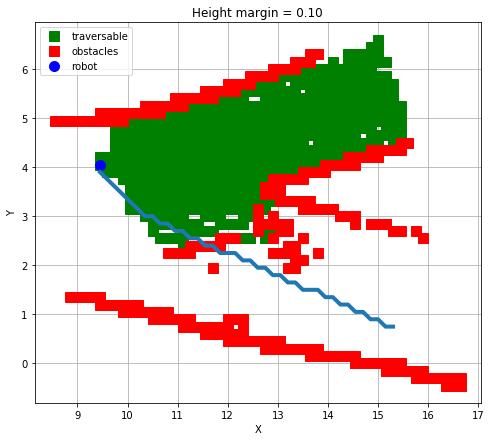

In [10]:
# visualize everithing
plt.figure(figsize=(int(np.max(X)-np.min(X)), int(np.max(Y)-np.min(Y))))
plt.plot(X[Z<=margin], Y[Z<=margin], 's', color='green', label='traversable', markersize=10)
plt.plot(X[Z>margin], Y[Z>margin], 's', color='red', label='obstacles', markersize=10)
plt.plot(robot_pose[0], robot_pose[1], 'ro', color='b', markersize=10, label='robot')
if len(path)>0: plt.plot(path[:,0], path[:,1], linewidth=4)

plt.title('Height margin = %.2f'%margin)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid()

### Breadth First Search to find nearest frontier to plan to

BFS: found a frontier


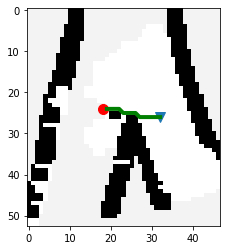

In [11]:
# start_grid = (int(robot_grid_pose[0]), int(robot_grid_pose[1]))
# choose random start location
while True:
    i,j = np.random.randint(0, grid.shape[0]), np.random.randint(0, grid.shape[1])
    if grid[i,j] != 1 and grid[i,j] != unexplored_value:
        start_grid = (i,j)
        break

path_grid, goal_grid = breadth_first_search(grid, start_grid, unexplored_value)

pp = np.array(path_grid)
plt.imshow(1-grid, cmap='gray')
plt.plot(start_grid[1], start_grid[0], 'v', markersize=10)
plt.plot(goal_grid[1], goal_grid[0], 'ro', markersize=10)
if len(path_grid)>0: plt.plot(pp[:, 1], pp[:, 0], 'g', linewidth=4)

In [12]:
path = [(np.array(point)*map_res+[x_min, y_min]).tolist()+[elev_grid[point]] for point in path_grid]
path = np.array(path)

### Try different configurations

BFS: found a frontier
Path planning took 0.11732959747314453 sec


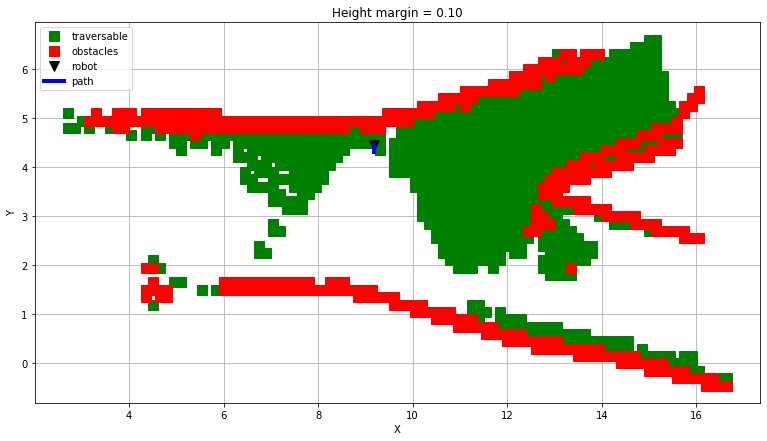

BFS: found a frontier
Path planning took 0.16115903854370117 sec


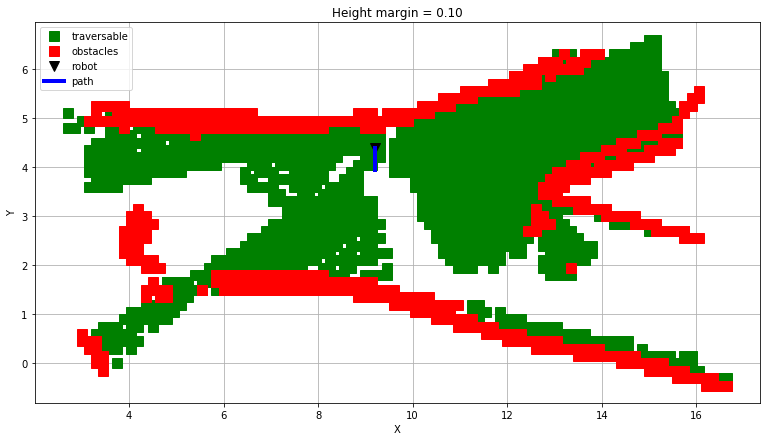

BFS: found a frontier
Path planning took 0.18066668510437012 sec


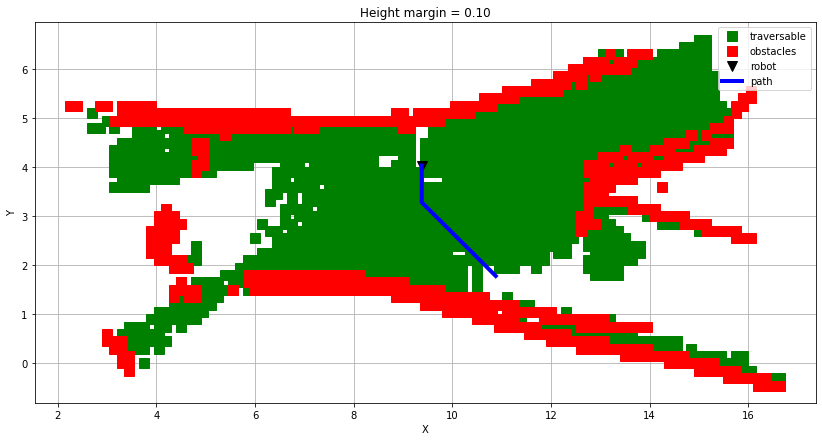

BFS: found a frontier
Path planning took 0.19551563262939453 sec


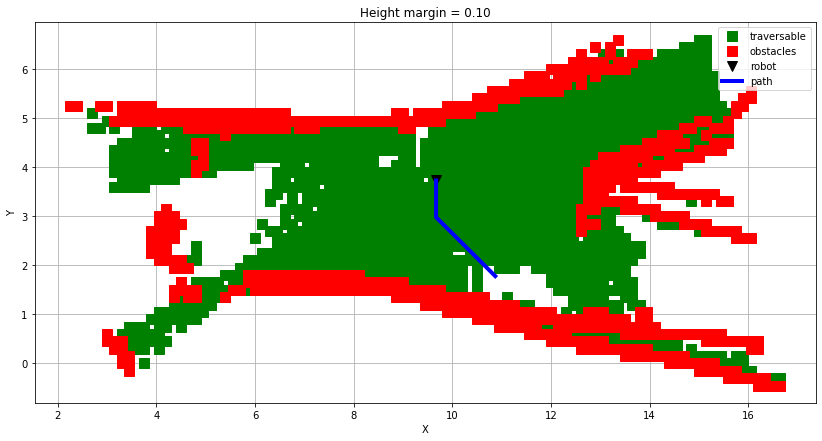

BFS: found a frontier
Path planning took 0.20516085624694824 sec


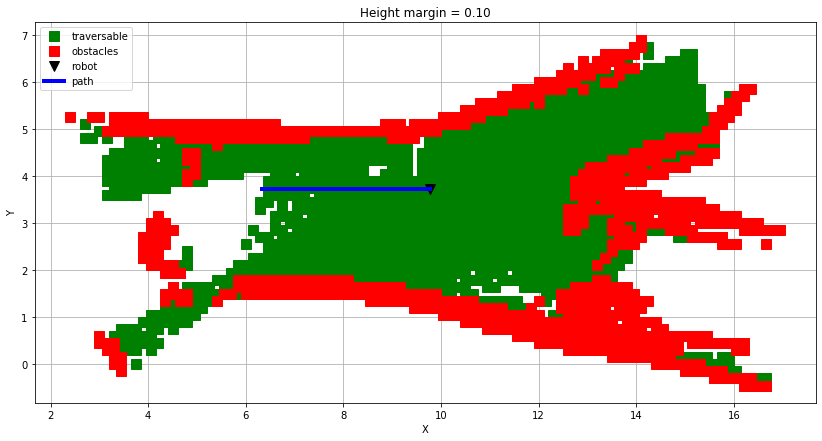

BFS: found a frontier
Path planning took 0.21013259887695312 sec


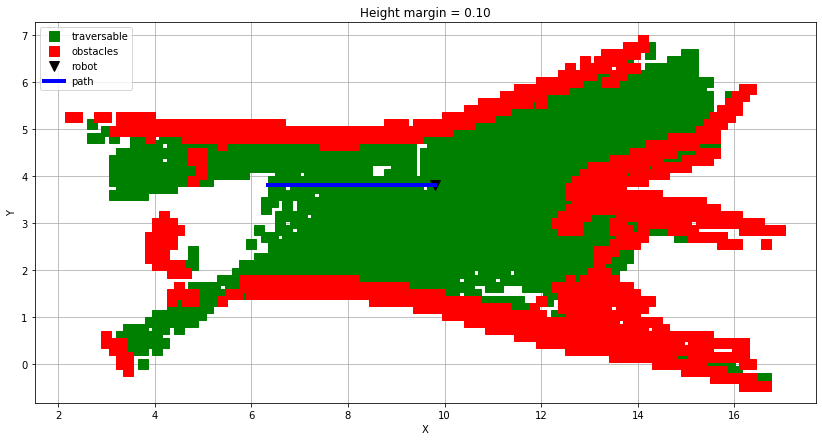

BFS: found a frontier
Path planning took 0.20485901832580566 sec


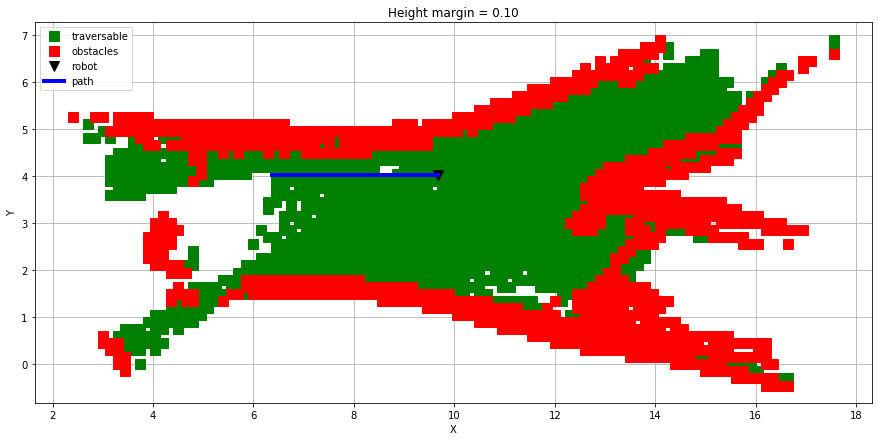

BFS: found a frontier
Path planning took 0.21045947074890137 sec


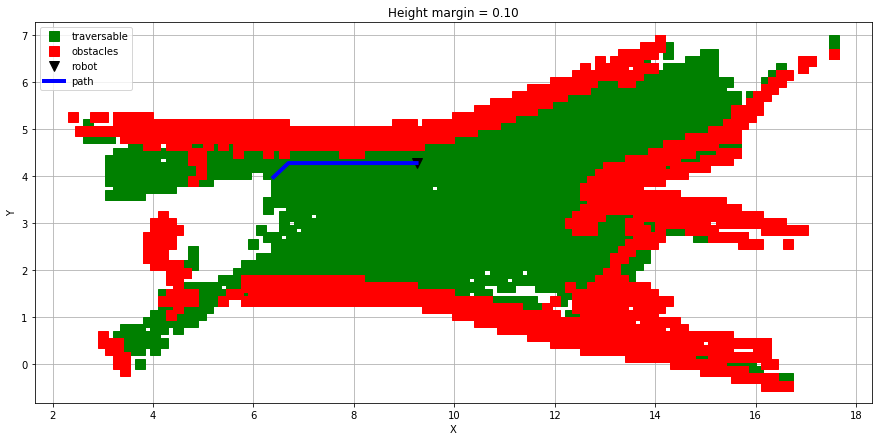

BFS: found a frontier
Path planning took 0.2254199981689453 sec


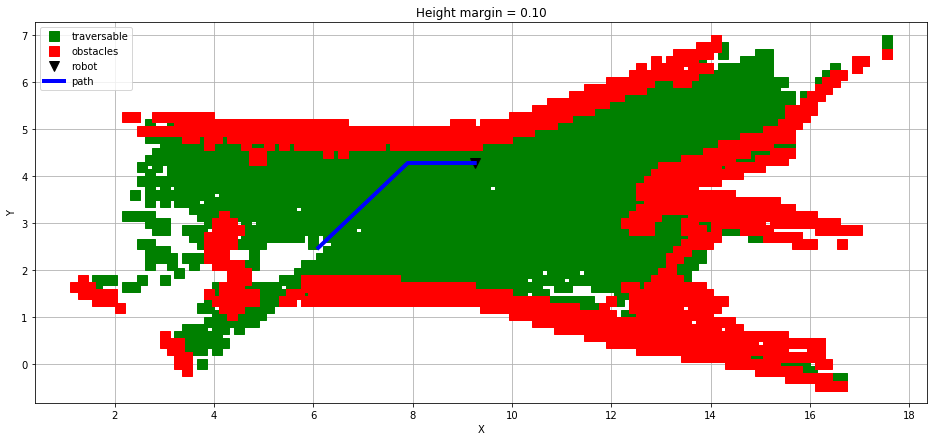

BFS: found a frontier
Path planning took 0.23235130310058594 sec


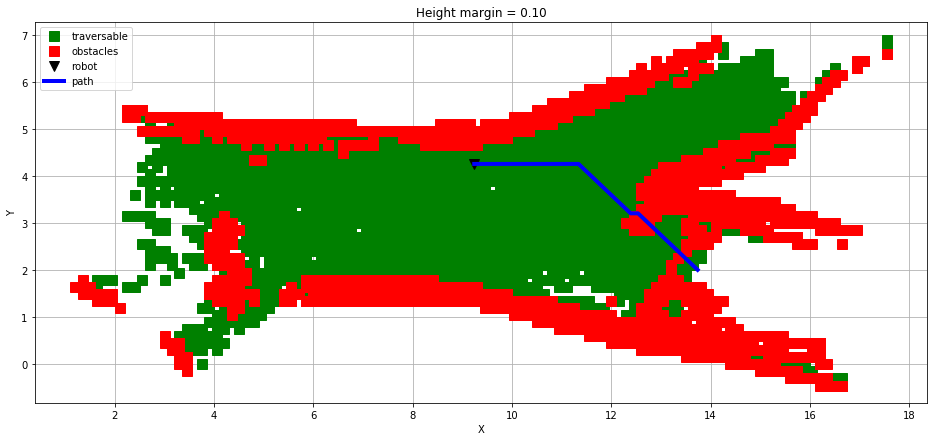

In [13]:
for ind in range(25, 35):
    # read data
    elev_map = np.load('./data/elev_map{}.npy'.format(ind))
    dynamic_pc = np.load('./data/dynamic_pc{}.npy'.format(ind))
    robot_pose = np.load('./data/robot_pose{}.npy'.format(ind))
    # elev_map = dynamic_pc

    tic = time.time()
    grid, elev_grid = create_grid(elev_map, robot_pose[2], map_res, margin, safety_distance, unexplored_value)
    x_min, y_min = np.min(elev_map[:, 0]), np.min(elev_map[:, 1])

    # define start on a grid
    robot_grid_pose = (robot_pose - [x_min, y_min, 0]) // map_res
    start_grid = (int(robot_grid_pose[0]), int(robot_grid_pose[1]))

    path_grid, goal_grid = breadth_first_search(grid, start_grid, unexplored_value)
    # transform path to map coordintes (m)
    path = [(np.array(point)*map_res+[x_min, y_min]).tolist()+[elev_grid[point]] for point in path_grid]
    if len(path)>0:
        path = prune_path(path, 1e-3)
    #     path = smooth_path(np.array(path), vis=1)
    path = np.array(path) - path[0,:] + robot_pose # start path exactly from robot location
    print('Path planning took {} sec'.format(time.time()-tic))
    
    # visualize everithing
    X = elev_map[:,0]; Y = elev_map[:,1]; Z = elev_map[:,2]
    dZ = Z - robot_pose[2]
    plt.figure(figsize=(int(np.max(X)-np.min(X)), int(np.max(Y)-np.min(Y))))
    plt.plot(X[dZ<=margin], Y[dZ<=margin], 's', color='green', label='traversable', markersize=10)
    plt.plot(X[dZ>margin], Y[dZ>margin], 's', color='red', label='obstacles', markersize=10)
    plt.plot(robot_pose[0], robot_pose[1], 'v', color='k', markersize=10, label='robot')
    plt.plot(path[:,0], path[:,1], color='b', linewidth=4, label='path')

    plt.title('Height margin = %.2f'%margin)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid()
    plt.show()

### APF to generate smooth trajectories

In [14]:
from planning import apf_planner, apf_path_to_map, draw_gradient

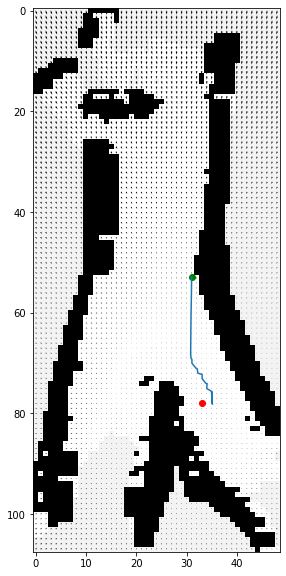

In [15]:
# define start and goal locations on a grid
start = (np.array([robot_pose[1], robot_pose[0]]) - [y_min, x_min]) // map_res
while True:
    i,j = np.random.randint(0, grid.shape[0]), np.random.randint(0, grid.shape[1])
    if grid[i,j] != 1:
        goal = [j, i]
        break
# goal = [20, 10]

# plan a path on a grid
path_grid, total_potential = apf_planner(grid, start, goal, max_apf_iters, influence_r, repulsive_coef, attractive_coef)
path_grid = np.array(path_grid)

plt.figure(figsize=(10,10))
plt.imshow(1-grid, cmap='gray')
plt.plot(goal[0], goal[1], 'ro')
plt.plot(start[0], start[1], 'ro', color='g')
plt.plot(path_grid[:,0], path_grid[:,1])
draw_gradient(total_potential)

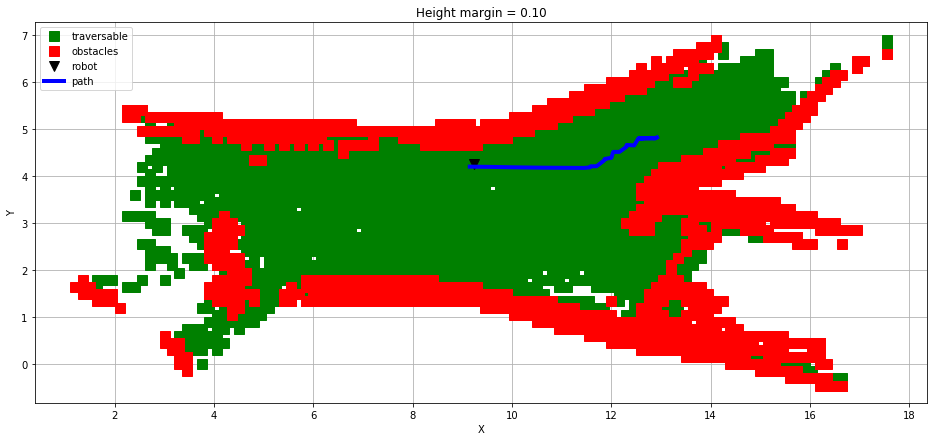

In [16]:
# convert to map coordinates
path_map = apf_path_to_map(path_grid, elev_map, elev_grid, map_res)

# visualize everithing
X = elev_map[:,0]; Y = elev_map[:,1]; Z = elev_map[:,2]
dZ = Z-robot_pose[2]
plt.figure(figsize=(int(np.max(X)-np.min(X)), int(np.max(Y)-np.min(Y))))
plt.plot(X[dZ<=margin], Y[dZ<=margin], 's', color='green', label='traversable', markersize=10)
plt.plot(X[dZ>margin], Y[dZ>margin], 's', color='red', label='obstacles', markersize=10)
plt.plot(robot_pose[0], robot_pose[1], 'v', color='k', markersize=10, label='robot')
path_map = np.array(path_map)
plt.plot(path_map[:,0], path_map[:,1], color='b', linewidth=4, label='path')

plt.title('Height margin = %.2f'%margin)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid()
plt.show()

### BFS as a global planner and APF as a local

In this setup a BFS algorithm is used to find a nearest frontier to explore. While APF plans the trajectory from robot's current position to the goal defined from BFS.
It is also possible to utilize a trajectory, defined by BFS. However this trajectories are usualy too close to obstacles and are not smooth.

In [17]:
def grid_to_map(point, elev_map, elev_grid, map_res=0.15):
    x_min, y_min = np.min(elev_map[:, 0]), np.min(elev_map[:, 1])
    i = int(np.clip(point[0], 0, elev_grid.shape[0]-1))
    j = int(np.clip(point[1], 0, elev_grid.shape[1]-1))
    z = elev_grid[i, j]
    return (np.array(point)*map_res+[x_min, y_min]).tolist() + [z]

BFS: found a frontier
Path planning took 0.2019517421722412 sec


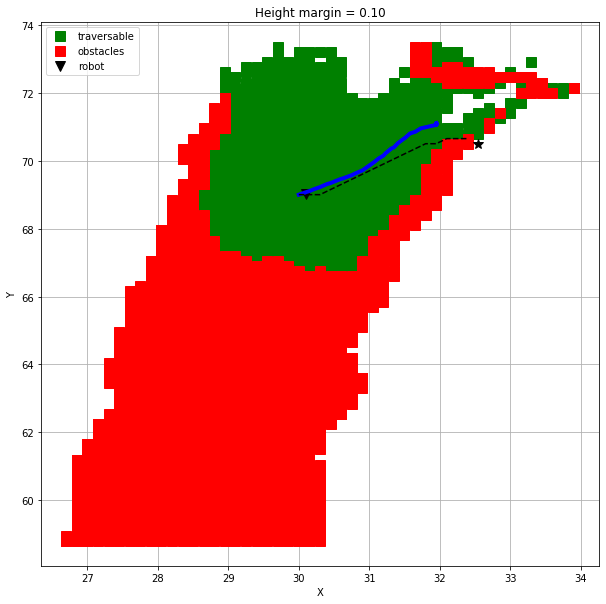

BFS: found a frontier
Path planning took 0.2009119987487793 sec


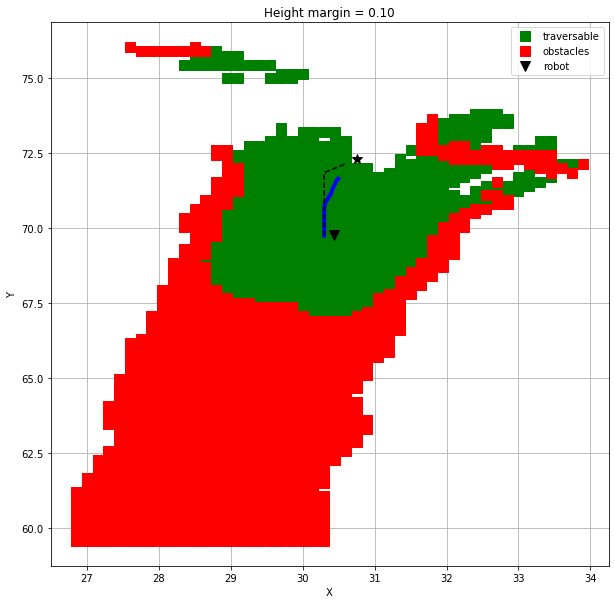

BFS: found a frontier
Path planning took 0.22250151634216309 sec


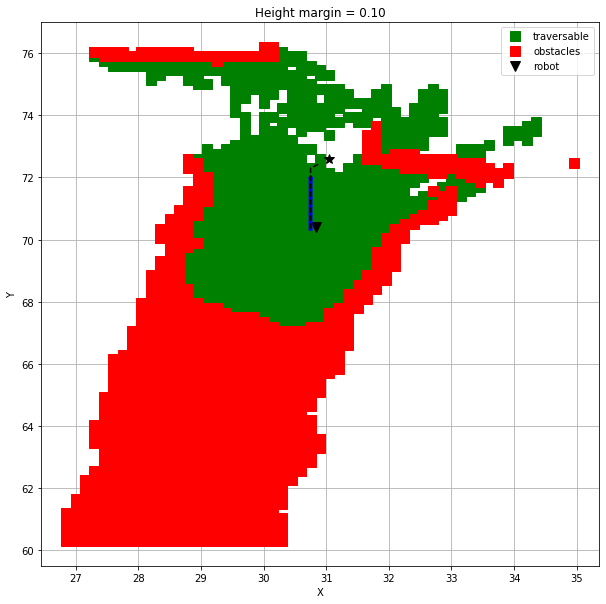

BFS: found a frontier
Path planning took 0.22907781600952148 sec


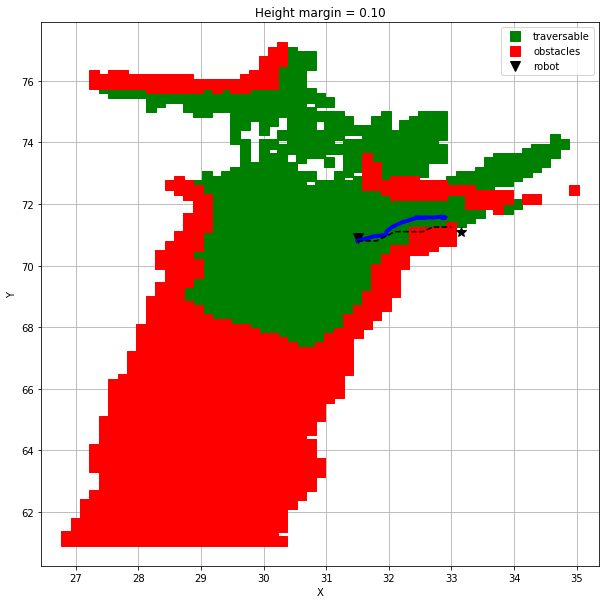

BFS: found a frontier
Path planning took 0.22138547897338867 sec


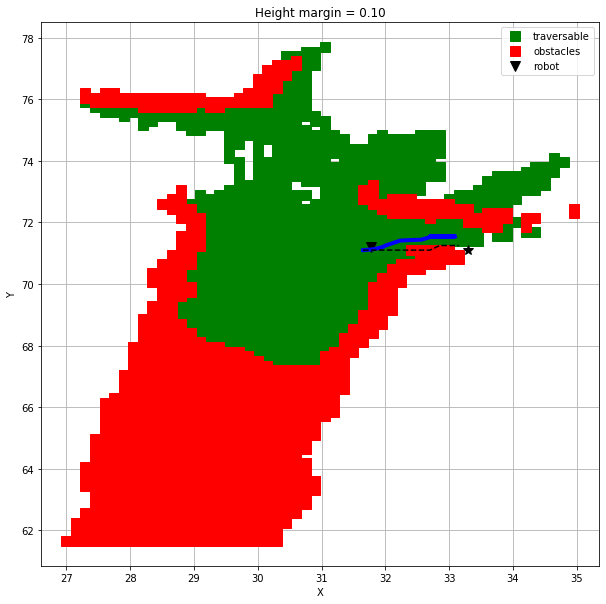

BFS: found a frontier
Path planning took 0.2424943447113037 sec


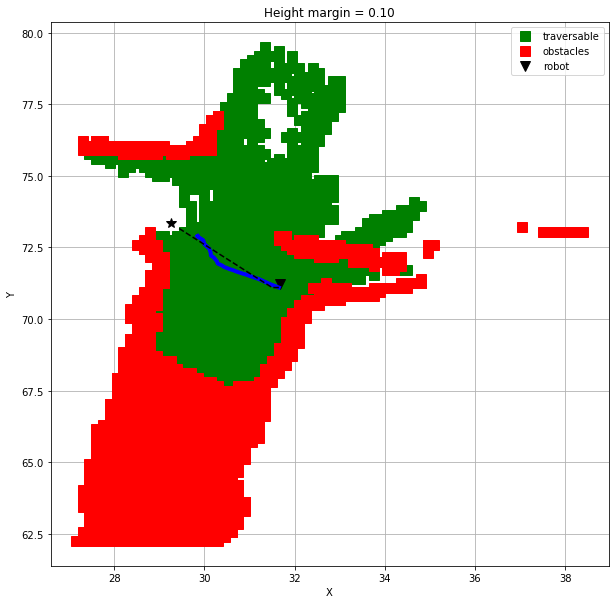

BFS: found a frontier
Path planning took 0.2386925220489502 sec


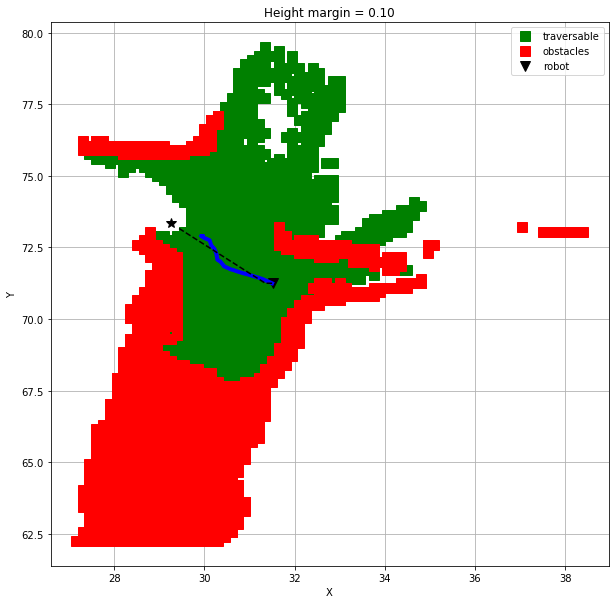

BFS: found a frontier
Path planning took 0.25075721740722656 sec


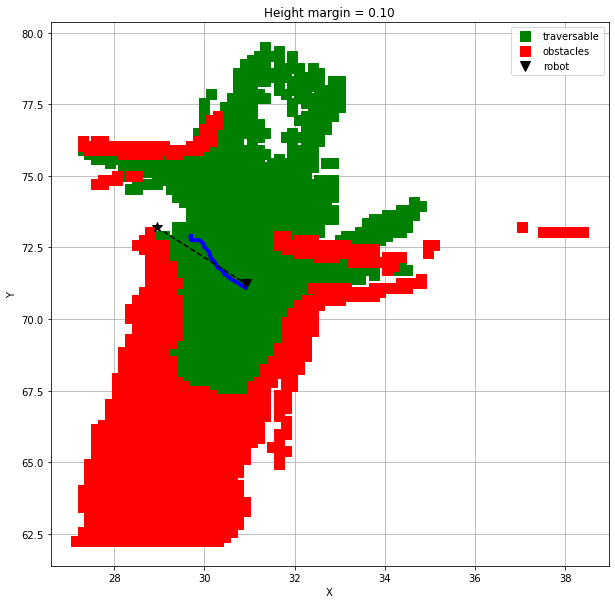

BFS: found a frontier
Path planning took 0.2627387046813965 sec


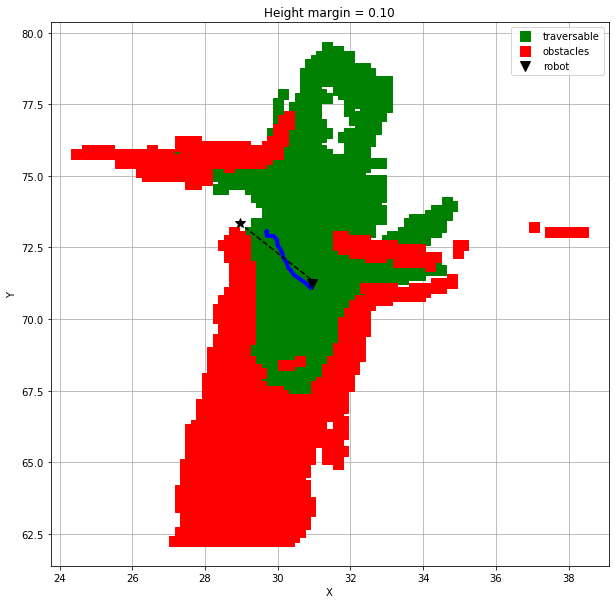

BFS: found a frontier
Path planning took 0.2753574848175049 sec


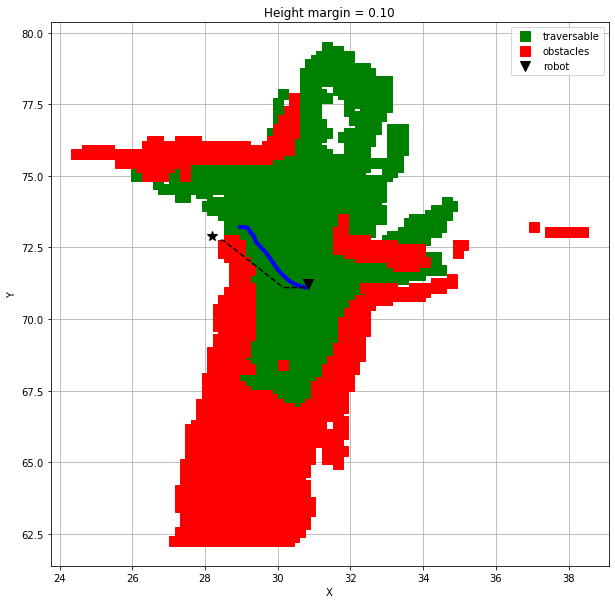

BFS: found a frontier
Path planning took 0.29636120796203613 sec


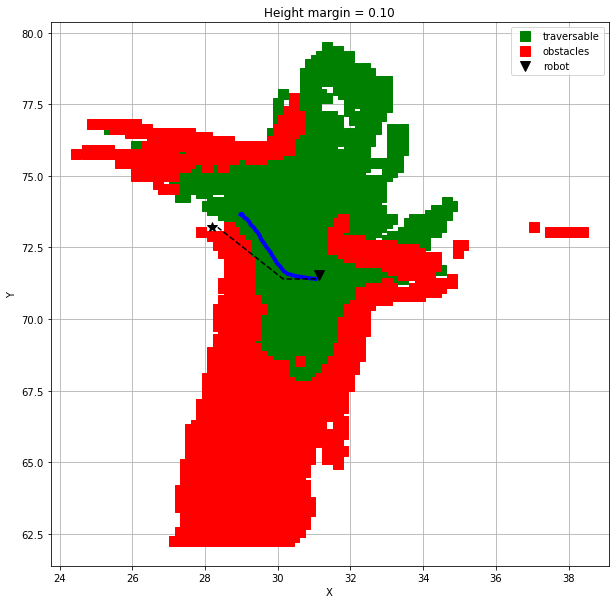

BFS: found a frontier
Path planning took 0.3000681400299072 sec


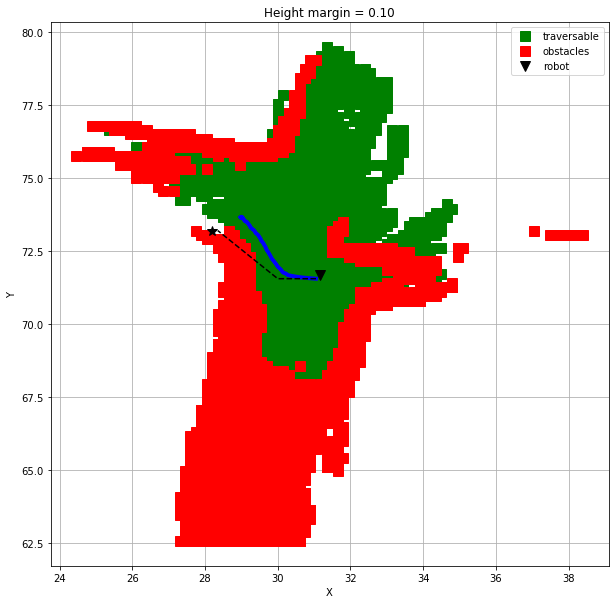

BFS: found a frontier
Path planning took 0.29583001136779785 sec


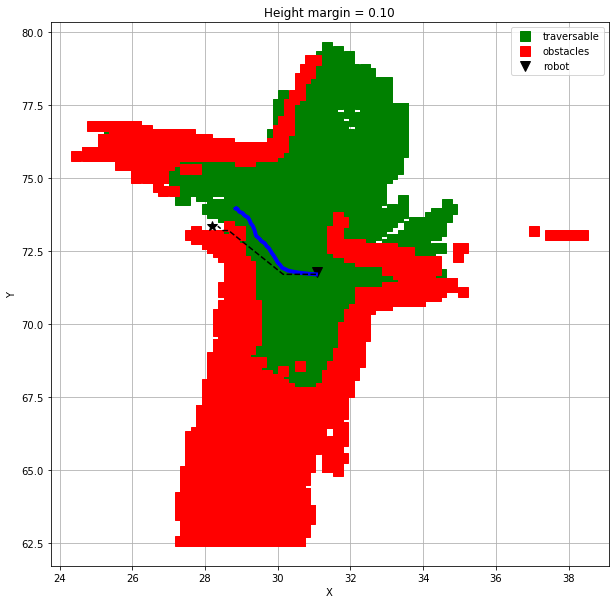

BFS: found a frontier
Path planning took 0.3040947914123535 sec


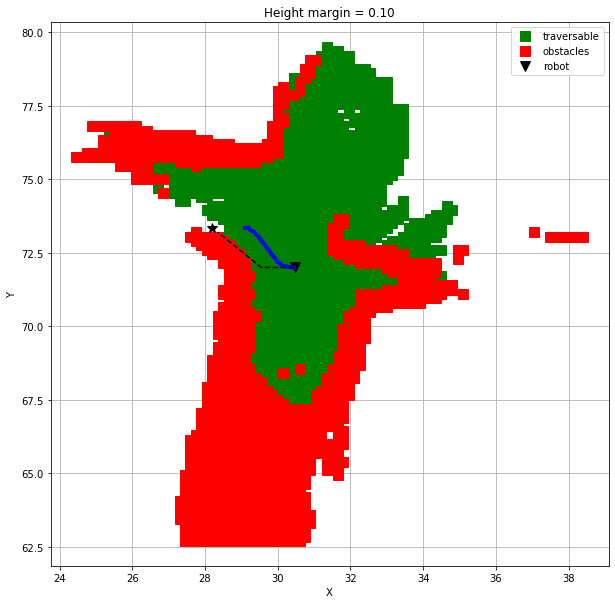

In [21]:
for ind in range(200, 214):
    # read data
    elev_map = np.load('./data/elev_map{}.npy'.format(ind))
    dynamic_pc = np.load('./data/dynamic_pc{}.npy'.format(ind))
    robot_pose = np.load('./data/robot_pose{}.npy'.format(ind))
    # elev_map = dynamic_pc

    tic = time.time()
    grid, elev_grid = create_grid(elev_map, robot_pose[2],
                                  map_res=map_res,
                                  safety_distance=safety_distance,
                                  margin=margin,
                                  unexplored_value=unexplored_value)
    x_min, y_min = np.min(elev_map[:, 0]), np.min(elev_map[:, 1])

    # define start on a grid
    robot_grid_pose = (robot_pose - [x_min, y_min, 0]) // map_res
    start_grid = (int(robot_grid_pose[0]), int(robot_grid_pose[1]))

    bfs_path_grid, goal_grid = breadth_first_search(grid, start_grid, unexplored_value)
    
    if goal_grid is not None:
        # compute APF path on a grid
        apf_path_grid, total_potential = apf_planner(grid, [start_grid[1], start_grid[0]], [goal_grid[1], goal_grid[0]],
                                    max_apf_iters, influence_r, repulsive_coef, attractive_coef)
        # transform path to map coordintes (m)
        apf_path = apf_path_to_map(apf_path_grid, elev_map, elev_grid, map_res)
        print('Path planning took {} sec'.format(time.time()-tic))
    
    # BFS path
    # transform path to map coordintes (m)
    bfs_path = [(np.array(point)*map_res+[x_min, y_min]).tolist()+[elev_grid[point]] for point in bfs_path_grid]
    bfs_path = np.array(bfs_path)
    
    # visualize everithing
    X = elev_map[:,0]; Y = elev_map[:,1]; Z = elev_map[:,2]
    dZ = Z - robot_pose[2]
    
    plt.figure(figsize=(10,10))
    plt.plot(X[dZ<=margin], Y[dZ<=margin], 's', color='green', label='traversable', markersize=10)
    plt.plot(X[dZ>margin], Y[dZ>margin], 's', color='red', label='obstacles', markersize=10)
    plt.plot(robot_pose[0], robot_pose[1], 'v', color='k', markersize=10, label='robot')
    plt.title('Height margin = %.2f'%margin)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid()
    if goal_grid is not None:
        path = np.array(apf_path)
        plt.plot(path[:,0], path[:,1], color='b', linewidth=4, label='apf_path')
        plt.plot(bfs_path[:,0], bfs_path[:,1], '--', color='k', label='bfs_path')
        frontier_goal = grid_to_map(goal_grid, elev_map, elev_grid)
        plt.plot(frontier_goal[0], frontier_goal[1], '*', markersize=10, color='k', label='frontier goal')

    plt.show()